In [1]:
import os
import sys
import json
import argparse
from typing import *
from tqdm import *
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
try:
  from ..utils.logger import logger
  from ..utils.utils import *
except ImportError:
  from utils.logger import logger
  from utils.utils import *

In [2]:
# import numpy as np
# from scipy import integrate
# #import matplotlib.pyplot as plt
# import sympy

# def apply_ics(sol, ics, x, known_params):
# 	free_params = sol.free_symbols - set(known_params)
#     ## free parameters like C1,C2, that needed to be figured out with ics and boundary conditions
# 	eqs = [(sol.lhs.diff(x, n) - sol.rhs.diff(x, n)).subs(x, 0).subs(ics) for n in range(len(ics))]
#     ## form equations with general solution(sol), by substituting the x with 0 and [y(0),dy/dx(x=0)...] with ics.
# 	sol_params = sympy.solve(eqs, free_params)
#     ## solve the algebraic equation set  to get the free parameters expression
#     ## return the solution after substituting the free parameters

# 	return sol.subs(sol_params)

# sympy.init_printing()
# ## initialize the print environment
# t = sympy.Symbol("t")
# ## symbolize the parameters and they can only be positive
# x1 = sympy.Function('x_1')
# x2 = sympy.Function('x_2')
# ## set x to be the differential function, not the variable
# f1 = 80000 * (x1(t) - x2(t)) + 10000 * (x1(t).diff(t) - x2(t).diff(t)) - x2(t).diff(t, 2) * 2433
# f2 = 80000 * (x1(t) - x2(t)) + 10000 * (x1(t).diff(t) - x2(t).diff(t)) - 6250 * sympy.cos(1.0045 * t) * x2(t).diff(t, 2) + \
#         1e3 * 9.8 * sympy.pi * x1(t) + 656.3616 * x1(t).diff(t) + 1335.535 * x1(t).diff(t, 2) + 4866 * x1(t).diff(t, 2)
# sol = sympy.dsolve(f1, f2)
# ## use diff() and dsolve to get the general solution
# ics = {x1(0): 0, x1(t).diff(t).subs(t, 0): 0, x2(0): 0, x2(t).diff(t).subs(t, 0): 0}
# ## apply dict to the initial conditions
# t_sol = apply_ics(solsol, ics, t, [])
# ## get the solution with ics by calling function apply_ics.
# sympy.pprint(t_sol)
# print(t_sol)
# ## pretty print
# ## solution is as follows

In [3]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
session = WolframLanguageSession()

In [4]:
session.evaluate("""
M = 4866; m = 2433; k2 = 80000; c2 = 10000; omega = 2.2143; k1 = 1025 * 9.8 * Pi;
f = 4890; c1 = 167.8395; m0 = 1165.992;
start = 510; stop = 520; dim = 1;
P2[cm2_] := Sum[cm2 * ((x1'[i] - x2'[i])^2) * dim, {i, start, stop, dim}] /. 
  NDSolve[{m*x2''[t]==k2*(x1[t]-x2[t])+cm2*(x1'[t]-x2'[t]), 
    f*Cos[omega * t]==k2*(x1[t]-x2[t])+cm2*(x1'[t]-x2'[t])+k1*x1[t]+c1*x1'[t]+m0*x1''[t]+M*x1''[t], 
    x1[0]==x2[0]==x1'[0]==x2'[0]==0},
  {x1, x2}, {t, start, stop}]""")

In [5]:
def PP2(x, d):
  return session.evaluate(wl.Evaluate(wlexpr(f'First[P2[{x}]-P2[{x-d}]]')))

In [6]:
def find(start, stop, f, esp=2*1e-5, n=100):
  d = (stop - start) / n
  print(f"find({start}, {stop}, {d})")
  m = (start + stop) / 2
  v = f(m, d)
  if abs(v) < esp:
    return [m, v]
  if v < 0:
    return find(start, m, f)
  return find(m, stop, f)

find(0, 100000, PP2)

find(0, 100000, 1000.0)
find(0, 50000.0, 500.0)
find(25000.0, 50000.0, 250.0)
find(25000.0, 37500.0, 125.0)
find(31250.0, 37500.0, 62.5)
find(34375.0, 37500.0, 31.25)
find(34375.0, 35937.5, 15.625)
find(34375.0, 35156.25, 7.8125)
find(34375.0, 34765.625, 3.90625)
find(34375.0, 34570.3125, 1.953125)
find(34472.65625, 34570.3125, 0.9765625)
find(34472.65625, 34521.484375, 0.48828125)
find(34472.65625, 34497.0703125, 0.244140625)
find(34472.65625, 34484.86328125, 0.1220703125)
find(34472.65625, 34478.759765625, 0.06103515625)
find(34472.65625, 34475.7080078125, 0.030517578125)
find(34472.65625, 34474.18212890625, 0.0152587890625)
find(34472.65625, 34473.419189453125, 0.00762939453125)
find(34473.03771972656, 34473.419189453125, 0.003814697265625)
find(34473.228454589844, 34473.419189453125, 0.0019073486328125)
find(34473.228454589844, 34473.323822021484, 0.00095367431640625)
find(34473.276138305664, 34473.323822021484, 0.000476837158203125)
find(34473.299980163574, 34473.323822021484, 0.0

[34473.31529058477, 0.0]

In [3]:
'''
CalcP22[kStart_, kStop_, kStepNum_, eStart_, eStop_, eStepNum_] := 
  Table[{e, k, First[P22[k, e]]}, 
    {k, Range[kStart, kStop, (kStop-kStart)/kStepNum]}, 
    {e, Range[eStart, eStop, (eStop-eStart)/eStepNum]}]
DrawP22[data_] := ListPlot3D[Flatten[data, 1]]
'''

'\nCalcP22[kStart_, kStop_, kStepNum_, eStart_, eStop_, eStepNum_] := \n  Table[{e, k, First[P22[k, e]]}, \n    {k, Range[kStart, kStop, (kStop-kStart)/kStepNum]}, \n    {e, Range[eStart, eStop, (eStop-eStart)/eStepNum]}]\nDrawP22[data_] := ListPlot3D[Flatten[data, 1]]\n'

In [8]:
# session.evaluate(P22)

In [9]:
# session.evaluate(wlexpr("First[P22[10000, 0.6]]"))

In [10]:
# import nest_asyncio
# nest_asyncio.apply()
# import asyncio
# from wolframclient.evaluation import WolframLanguageSession
# from wolframclient.language import wl, wlexpr
# from wolframclient.evaluation import WolframEvaluatorPool
# from wolframclient.evaluation import parallel_evaluate
# # expressions = ['Pause[1]; $ProcessID' for _ in range(10)]
# expressions = [f'Print[{i}]; {i}' for i in range(10)]
# # expressions = ['$ProcessID' for _ in range(10)]
# # parallel_evaluate(expressions, max_evaluators=20)

# pool = WolframEvaluatorPool()
# async def test_pool():
#   return await asyncio.gather(*[pool.evaluate(f"{i}^2") for i in range(10)])

# async def test_pool_loop():
#   for i in range(4):
#     print(f"done {i}", await test_pool())
  
# # asyncio.run(test_pool_loop())
  

In [5]:
import math
import nest_asyncio
nest_asyncio.apply()
import random
import matplotlib.pyplot as plt
from wolframclient.language import wl, wlexpr
from wolframclient.evaluation import WolframLanguageSession
# from wolframclient.evaluation import parallel_evaluate
import asyncio
import time
import queue
import threading

P22 = """
start = 510; stop = 520; dim = 1;
M = 4866; m = 2433; k = 80000; c = 10000; omega = 2.2143; k1 = 1025 * 9.8 * Pi;
f = 4890; c0 = 167.8395; m0 = 1165.992;
cmv2[v_, ck_, ce_] := ck * Abs[v]^ce;
P22I[ck_, ce_] := NDSolve[{m*x2''[t]==k*(x1[t]-x2[t])+cmv2[x1'[t]-x2'[t], ck, ce]*(x1'[t]-x2'[t]), 
    f*Cos[omega * t]==k*(x1[t]-x2[t])+cmv2[x1'[t]-x2'[t], ck, ce]*(x1'[t]-x2'[t])+k1*x1[t]+c0*x1'[t]+m0*x1''[t]+M*x1''[t], 
    x1[0]==x2[0]==x1'[0]==x2'[0]==0},
  {x1, x2}, {t, start, stop}]
P22[ck_, ce_] := Sum[cmv2[x1'[i]-x2'[i], ck, ce+2] * dim, {i, start, stop, dim}] /. P22I[ck, ce]
"""

queue_task = queue.Queue()
queue_res = queue.Queue()

random.seed(114514)

threads = []

thread_num = 14

def thread_run():
    # print("thread start:", threading.current_thread())
    session = WolframLanguageSession()
    session.evaluate(P22)
    # print("test exec:", session.evaluate(wlexpr("P22[90000, 0.4]")))
    while True:
        try:
            try:
                task = queue_task.get(block=True, timeout=5)
                if task is None:
                    break
                # print("got", task)
                text = f"First[P22[{task[0]}, {task[1]}]]"
                try:
                    res = session.evaluate(wlexpr(text))
                    if not isinstance(res, float):
                        raise Exception("remote error")
                    # print("res", res, threading.current_thread())
                    queue_res.put({ "id": task[2], "task": task, "res": res, "ok": True })
                except Exception as e:
                    print(e, threading.current_thread())
                    queue_res.put({ 'id': task[2], "ok": False })
                    continue
            except queue.Empty as e:
                # print("timeout")
                continue
        except Exception as e:
            print(e, threading.current_thread())
            queue_res.put({ 'id': -1, "ok": False })
            continue
    print("thread done:", threading.current_thread())
        

def thread_pool_init():
    threads = [threading.Thread(target=thread_run, daemon=True) for _ in range(thread_num)]
    # [t.setDaemon(True) for t in threads]
    [t.start() for t in threads]

def parallel_evaluate(exps, retry=0, **kwargs):
    # print("parallel_evaluate", exps)
    exps = [(*exps[i], i) for i in range(len(exps))]
    [queue_task.put(i) for i in exps]
    results = [queue_res.get(block=True) for _ in range(len(exps))]
    failed = [it['id'] for it in results if not it['ok']]
    if len(failed) > 0:
        [queue_task.put(exps[failed[i]]) for i in range(len(failed)) if failed[i] > 0]
        results2 = [queue_res.get(block=True, timeout=15) for _ in range(len(failed))]
        results = [it for it in results if it['ok']]
        results.extend(results2)
    failed = [it['id'] for it in results if not it['ok']]
    # results = [queue_res.get(block=True, timeout=15) for _ in range(len(exps))]
    results.sort(key=lambda x: x['id'])
    res = [it['res'] for it in results if it['id'] >= 0 and it['ok']]
    if len(failed) > 0 or len(results) != len(exps):
        # time.sleep(2)
        print(res, failed)
        if retry >= 3:
            raise Exception("Has failed data!!!")
        else:
            return parallel_evaluate(exps, retry=retry + 1)
    return res

tot = 0
def func(x, y):                  #函数优化问题
    global tot
    # res= 4*x**2-2.1*x**4+x**6/3+x*y-4*y**2+4*y**4
    # res = 3000 - pool.evaluate(wlexpr(f"First[P22[{x}, {y}]]"))
    tot += 1
    # return res
    # text = f"First[P22[{x}, {y}]]"
    # # print(f"run: {text}")
    # return wlexpr(text)
    return (x, y)

ERR_RAND = 0

#x为公式里的x1,y为公式里面的x2
class SA:
    def __init__(self, func, iter=thread_num, T0=thread_num, Tf=10, alpha=0.99, x_range=None, y_range=None, sx=None, sy=None):
        self.func = func
        self.iter = iter         #内循环迭代次数,即为L =100
        self.alpha = alpha       #降温系数，alpha=0.99
        self.T0 = T0             #初始温度T0为100
        self.Tf = Tf             #温度终值Tf为0.01
        self.T = T0              #当前温度
        self.x_range = [0, 100000] if x_range is None else x_range
        self.y_range = [0, 1.0] if y_range is None else y_range
        self.x = [random.random() * (self.x_range[1] - self.x_range[0]) + self.x_range[0] for i in range(iter)] #随机生成100个x的值
        self.y = [random.random() * (self.y_range[1] - self.y_range[0]) + self.y_range[0] for i in range(iter)] #随机生成100个y的值
        self.thread_num = iter
        self.most_best =[]
        self.history = {'f': [], 'T': []}
        self.best_F = 1e10
        self.best_res = None
        self.sx = sx if sx is not None else self.x[0]
        self.sy = sy if sy is not None else self.y[0]

    def generate_new(self, x, y):   #扰动产生新解的过程
        global ERR_RAND
        while True:
            # dx = self.T / self.T0 * (random.random() * (self.x_range[1] - self.x_range[0]) + self.x_range[0])
            # dy = self.T / self.T0 * (random.random() * (self.y_range[1] - self.y_range[0]) + self.y_range[0])
            dx = self.T / self.T0 * (random.random() - random.random()) * (self.x_range[1] - self.x_range[0])
            dy = self.T / self.T0 * (random.random() - random.random()) * (self.y_range[1] - self.y_range[0])
            x_new = x + dx
            y_new = y + dy
            # x_new = max(x_new, self.x_range[0] - 1e3)
            # x_new = min(x_new, self.x_range[1] + 1e3)
            # y_new = max(y_new, self.y_range[0] - 1)
            # y_new = min(y_new, self.y_range[1] + 1)
            if (self.x_range[0] <= x_new <= self.x_range[1]) and (self.y_range[0] <= y_new <= self.y_range[1]):
                ERR_RAND = 0
                # print("done", x_new, y_new)
                break                                  #重复得到新解，直到产生的新解满足约束条件
            else:
                # print(f"(dx, dy) = ({dx}, {dy})", f"(x_new, y_new) = ({x_new}, {y_new})", 
                #     (self.x_range[0] <= x_new <= self.x_range[1]), (self.y_range[0] <= y_new <= self.y_range[1]))
                ERR_RAND += 1
                # if ERR_RAND > 30:
                #     raise Exception("ERR_RAND overflow!")
        return x_new, y_new 

    def generate_directions(self):
        x, y = self.sx, self.sy
        # print(x, y)
        d = lambda r: self.T / self.T0 * r * 1 + 1 * (random.random() - random.random()) * r
        # d = lambda r: self.T / self.T0 * r * 1e-3
        # print(x, y, d(self.x_range[1] - self.x_range[0]), d(self.y_range[1] - self.y_range[0]))
        dirs = [[1, 0], [0, 1], [-1, 0], [0, -1]]
        ds = [(di[0] * d(self.x_range[1] - self.x_range[0]), di[1] * d(self.y_range[1] - self.y_range[0])) for di in dirs]
        def apply(dd):
            # print("dd=", dd)
            x_new, y_new = dd[0] + x, dd[1] + y
            x_new = max(x_new, self.x_range[0])
            x_new = min(x_new, self.x_range[1])
            y_new = max(y_new, self.y_range[0])
            y_new = min(y_new, self.y_range[1])
            return (x_new, y_new)
        res_dir = [apply(dd) for dd in ds]
        dscar = 0.3
        res_dir.extend([apply((dscar*d(self.x_range[1] - self.x_range[0]), dscar*d(self.y_range[1] - self.y_range[0]))) for _ in range(thread_num-4)])
        return res_dir
        

    def Metrospolis(self, f, f_new):   #Metropolis准则
        if f_new <= f:
            # print(f"accept: {f} => {f_new}")
            return True
        else:
            p = math.exp((f - f_new) / self.T)
            return random.random() < p

    def best(self):    #获取最优目标函数值
        f_list = []    #f_list数组保存每次迭代之后的值
        results = []
        exps = [self.func(self.x[i], self.y[i]) for i in range(self.iter)]
        # for i in range(self.iter):
        #     f = self.func(self.x[i], self.y[i])
        #     f_list.append(f)
        results_raw = parallel_evaluate(exps, max_evaluators=self.thread_num)
        f_list = [-i for i in results_raw]
        # print(f_list)
        f_best = min(f_list)
        
        idx = f_list.index(f_best)
        if f_best < self.best_F:
            self.best_res = (self.x[idx], self.y[idx])
        return f_best, idx    #f_best,idx分别为在该温度下，迭代L次之后目标函数的最优解和最优解的下标

    def run(self):
        count = 0
        last_f = parallel_evaluate([self.func(self.sx, self.sy)])[0]
        while self.T > self.Tf:
            new_pos = self.generate_directions()
            new_exps = [self.func(*p) for p in new_pos]
            new_results = parallel_evaluate(new_exps)
            # if len(new_results) != 4:
            #     raise Exception("aaaaa 4 needed!")
            self.history['f'].append(last_f)
            self.history['T'].append(self.T)
            max_index = -1
            for i in range(len(new_results)):
                if last_f < new_results[i]:
                    max_index = i
                    last_f = new_results[i]
                    self.sx = new_pos[i][0]
                    self.sy = new_pos[i][1]
            if max_index < 0:
                # print(f"NO WAY! last={last_f}, new_results={new_results}")
                pass
            else:
                print("Temp now:", self.T, f"F={last_f}, tot={tot}, x={self.sx}, y={self.sy}")
            self.T = self.T * self.alpha
            count += 1
        # #外循环迭代，当前温度小于终止温度的阈值
        # while self.T > self.Tf:       
        #     #内循环迭代100次
        #     exps = [self.func(self.x[i], self.y[i]) for i in range(self.iter)]
        #     exps_all = [*exps]
        #     xy_new = [self.generate_new(self.x[i], self.y[i]) for i in range(self.iter)]
        #     exps_new = [self.func(*xy_new[i]) for i in range(self.iter)]
        #     exps_all = [*exps_all, *exps_new]
        #     results_all = parallel_evaluate(exps_all, max_evaluators=self.thread_num)
        #     results_all = [-i for i in results_all]
        #     results_new, results_raw = results_all[self.iter:], results_all[:self.iter]
        #     assert(len(results_raw) == len(results_new))
        #     for i in range(self.iter): 
        #         f = results_raw[i]
        #         f_new = results_new[i]
        #         if self.Metrospolis(f, f_new):                         #判断是否接受新值
        #             self.x[i] = xy_new[i][0]             #如果接受新值，则把新值的x,y存入x数组和y数组
        #             self.y[i] = xy_new[i][1]
        #     # 迭代L次记录在该温度下最优解
        #     ft, idx = self.best()
        #     self.history['f'].append(ft)
        #     self.history['T'].append(self.T)
        #     #温度按照一定的比例下降（冷却）
        #     self.T = self.T * self.alpha        
        #     print("Temp now:", self.T, f"F={ft}, tot={tot}, x={self.x[idx]}, y={self.y[idx]}")
        #     count += 1
            
            # 得到最优解
        # f_best, idx = self.best()
        # if f_best < self.best_F:
        #     print(f"F={f_best}, x={self.x[idx]}, y={self.y[idx]}, count={count}")
        # else:
        #     print(f"F={self.best_F}, x={self.best_res[0]}, y={self.best_res[1]}, count={count}")
        print(f"x={self.sx}, y={self.sy}, F={last_f}")

thread_pool_init done
Temp now: 14 F=2545.683530566852, tot=1, x=90000, y=0.4
NO WAY! last=2545.683530566852, new_results=[2535.5376059090986, 1686.7617227476835, 1130.3945532704138, 2039.4035717585314, 2045.5797824638157, 2410.549953101551, 2348.466493536, 2432.9092219896374, 2383.081446140388, 2396.4049630718573, 2540.2330322428966, 2387.5684233074717, 2369.093718310368, 2222.310211439363]
Temp now: 13.86 F=2545.683530566852, tot=15, x=90000, y=0.4
Temp now: 13.7214 F=2546.8464174201863, tot=29, x=100000, y=0.4618806966650133
NO WAY! last=2546.8464174201863, new_results=[2546.8464174201863, 1809.749240884869, 5.8109366566294876, 1917.916951534517, 2284.618126290053, 2133.63745412208, 2028.5232455010514, 2308.3932778714175, 2401.5706410020703, 2022.8990792069749, 1929.0545009971192, 2317.7631183842072, 2289.274535952228, 2488.78675689538]
Temp now: 13.584185999999999 F=2546.8464174201863, tot=43, x=100000, y=0.4618806966650133
NO WAY! last=2546.8464174201863, new_results=[2546.8464174

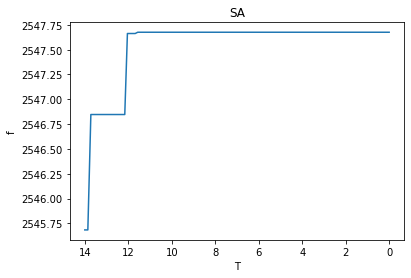

10095

In [7]:
tot = 0

thread_pool_init()
print("thread_pool_init done")
# sa = SA(func, x_range=[87000, 100000], y_range=[0.3, 0.5], Tf=10, sx=90000, sy=0.4)
sa = SA(func, x_range=[100, 100000], y_range=[0.1, 0.9], Tf=1e-2, sx=90000, sy=0.4)
# sa = SA(func, Tf=1e-2)
sa.run()

plt.plot(sa.history['T'], sa.history['f'])
plt.title('SA')
plt.xlabel('T')
plt.ylabel('f')
plt.gca().invert_xaxis()
plt.show()

tot

thread_pool_init done
Temp now: 19.8 F=-2531.82291488613, tot=60, x=39956.03404804763, y=0.07763265000391369
Temp now: 19.602 F=-2534.5652523004637, tot=120, x=45825.854294001176, y=0.11544683211353174
Temp now: 19.40598 F=-2534.691438325144, tot=180, x=46882.29659165022, y=0.1229416679936231
Temp now: 19.211920199999998 F=-2534.716029725268, tot=240, x=46085.071210141155, y=0.1185730658186738
Temp now: 19.019800997999997 F=-2534.691438325144, tot=300, x=46882.29659165022, y=0.1229416679936231
Temp now: 18.829602988019996 F=-2534.691438325144, tot=360, x=46882.29659165022, y=0.1229416679936231
Temp now: 18.641306958139797 F=-2534.691438325144, tot=420, x=46882.29659165022, y=0.1229416679936231
Temp now: 18.4548938885584 F=-2534.7527414744345, tot=480, x=49085.5459856577, y=0.13779059587727227
Temp now: 18.270344949672815 F=-2534.7527414744345, tot=540, x=49085.5459856577, y=0.13779059587727227
Temp now: 18.087641500176087 F=-2535.079561658825, tot=600, x=49537.47052129951, y=0.14273419

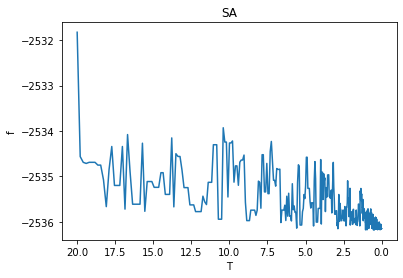

45440

In [12]:
# F=4.161369049798153, x=61003.081211318065, y=0.09541337660115246, count=230

tot = 0

thread_pool_init()
print("thread_pool_init done")
sa = SA(func, x_range=[30000, 50000], y_range=[0.01, 0.22], Tf=1e-2)
# sa = SA(func, Tf=1e-2)
sa.run()

plt.plot(sa.history['T'], sa.history['f'])
plt.title('SA')
plt.xlabel('T')
plt.ylabel('f')
plt.gca().invert_xaxis()
plt.show()

tot

thread_pool_init done
Temp now: 19.8 F=-2533.859747820394, tot=60, x=44392.454161773996, y=0.11831015093208265
Temp now: 19.602 F=-2533.859747820394, tot=120, x=44392.454161773996, y=0.11831015093208265


Socket exception: Socket operation aborted.
Failed to start.
Exception in thread Thread-28 (thread_run):
Traceback (most recent call last):
  File "/home/chiro/.local/lib/python3.10/site-packages/wolframclient/evaluation/kernel/kernelcontroller.py", line 435, in _kernel_start
    response = self.kernel_socket_in.recv_abortable(
  File "/home/chiro/.local/lib/python3.10/site-packages/wolframclient/evaluation/kernel/zmqsocket.py", line 50, in recv_abortable
    raise SocketAborted("Socket operation aborted.")
wolframclient.evaluation.kernel.zmqsocket.SocketAborted: Socket operation aborted.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/chiro/.conda/envs/cumcm/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/chiro/.conda/envs/cumcm/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_9452/129344928.py", line 23, in

Temp now: 19.40598 F=-2535.542397377513, tot=180, x=47899.37004801977, y=0.14114756185445076
Temp now: 19.211920199999998 F=-2535.69088074749, tot=240, x=48423.36729783287, y=0.14692411155098792
Temp now: 19.019800997999997 F=-2535.2113940845215, tot=300, x=47883.11059637868, y=0.14788209603107136
Temp now: 18.829602988019996 F=-2535.666145680543, tot=360, x=49279.693493719875, y=0.1459501327000023
Temp now: 18.641306958139797 F=-2535.719083165248, tot=420, x=48702.927741545835, y=0.15123578052840622
Temp now: 18.4548938885584 F=-2535.467425754098, tot=480, x=49714.02273124405, y=0.14655125464814278
Temp now: 18.270344949672815 F=-2535.467425754098, tot=540, x=49714.02273124405, y=0.14655125464814278
Temp now: 18.087641500176087 F=-2535.467425754098, tot=600, x=49714.02273124405, y=0.14655125464814278
Temp now: 17.906765085174325 F=-2535.467425754098, tot=660, x=49714.02273124405, y=0.14655125464814278
Temp now: 17.727697434322582 F=-2534.944505956976, tot=720, x=48670.763510838595, y=

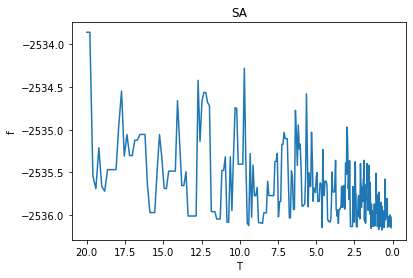

31700

In [14]:
# F=-2536.154751336053, x=49966.28976247785, y=0.15670386414624207, count=757

tot = 0

thread_pool_init()
print("thread_pool_init done")
sa = SA(func, x_range=[38000, 50000], y_range=[0.01, 0.22], Tf=1e-1)
# sa = SA(func, Tf=1e-2)
sa.run()

plt.plot(sa.history['T'], sa.history['f'])
plt.title('SA')
plt.xlabel('T')
plt.ylabel('f')
plt.gca().invert_xaxis()
plt.show()

tot

thread_pool_init done
Temp now: 19.8 F=-2536.1407005222272, tot=60, x=49854.34786759696, y=0.1570534430267182
Temp now: 19.602 F=-2536.117889690144, tot=120, x=49842.935224546076, y=0.15569298843700413
Temp now: 19.40598 F=-2536.1339290550486, tot=180, x=49901.836543254256, y=0.15612873397130395
Temp now: 19.211920199999998 F=-2536.1045848251665, tot=240, x=49728.73108042017, y=0.15634341607167287
Temp now: 19.019800997999997 F=-2536.1396503786946, tot=300, x=49879.58095164802, y=0.15655523154038958
Temp now: 18.829602988019996 F=-2536.147771478457, tot=360, x=49871.19167635426, y=0.15769711077294846
Temp now: 18.641306958139797 F=-2536.1158550981154, tot=420, x=49777.79490532742, y=0.15775414106115576
Temp now: 18.4548938885584 F=-2536.151079837531, tot=480, x=49911.6735335179, y=0.159323383272948
Temp now: 18.270344949672815 F=-2536.1805793399685, tot=540, x=49995.06765098612, y=0.15793465576254065
Temp now: 18.087641500176087 F=-2536.07985314315, tot=600, x=49666.95777959809, y=0.15

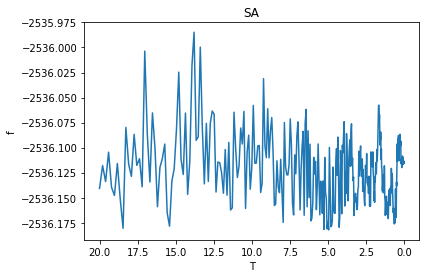

59180

In [15]:
# F=-2536.1471082671005, x=49869.70409139925, y=0.15754084216306088, count=528

tot = 0

thread_pool_init()
print("thread_pool_init done")
sa = SA(func, x_range=[49000, 50000], y_range=[0.14, 0.16], Tf=1e-3)
# sa = SA(func, Tf=1e-2)
sa.run()

plt.plot(sa.history['T'], sa.history['f'])
plt.title('SA')
plt.xlabel('T')
plt.ylabel('f')
plt.gca().invert_xaxis()
plt.show()

tot